## Let's Raise the *Roof!* Predicting the Energy of House Music.

**Introduction**  

Spotify is one of the largest music streaming services with over [406 million users](https://www.google.com/url?q=https://newsroom.spotify.com/company-info/&sa=D&source=docs&ust=1646548657733947&usg=AOvVaw2-aNiFTZDrkhXIWRxPE4aU) amounting to [75 million monthly listeners](https://dl.acm.org/doi/10.1145/2959100.2959120). The success of Spotify can be attributed towards the collection of user data, which allows for the curation of personalized playlists and recommended songs. Spotify has created a web API for public use, which grants users the ability to view information about artists and their songs. Amongst these functions, audio features can be gathered from songs, revealing several measures of their melody and lyrics.

For this exploration, the focus will be on songs from the [house music genre](https://www.allmusic.com/subgenre/house-ma0000002651?1646545415388&fbclid=IwAR2ZKQ2EAzLFX4E4FsCyNbLL17Y2Jrjmtqz0tW7dsIwkIn40YQT2QV1hYH8), which is a type of electronic dance music characterized by high energy, repeated beats, and synthesized sounds. As such, the purpose of this project is to create a predictive model for the energy rating for house music songs based on the other audio features, including acousticness, danceability, energy, liveness, loudness, speechiness, tempo, and valence.

given xyz, how can we predict the response?

For the dataset, the [Spotify web API](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) will be used to collect audio features for all the songs of the top 10 artists in the house music genre (Tiesto, Mashmello, Calvin Harris, The Chainsmokers, Alan Walker, Kygo, Diplo, Daft Punk, Martin Garrix, and Zedd). Collecting the audio features of their tracks provides us with several song metrics, of which we will be focusing on acousticness danceability, energy, liveness, loudness, speechiness, tempo, and valence.
  
**Attribute List**  
  
* `acousticness` - A measure from 0.0 to 1.0 of how natural a track is (not having synthetic or electric amplification)  
* `danceability` - A measure from 0.0 to 1.0 of how suitable a track is for dancing, based on tempo, rhythm stability, beat strength, regularity  
* `energy` - A measure from 0.0 to 1.0 of intensity, activity, and energy  
* `liveness` - A measure from 0.0 to 1.0 representing the probability of the presence of an audience  
* `loudness` - The average volume of a track in decibels (dB)  
* `speechiness` - A measure from 0.0 to 1.0 of the presence of spoken words  
* `tempo` - The overall estimated speed of the track in beats per minute (BPM)  
* `valence` - A measure from 0.0 to 1.0 denoting the positiveness conveyed by the track


**Data Analysis**

In [1]:
# loading required libraries
library(spotifyr)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(infer)
library(ggplot2)
library(GGally)
library(cowplot)
library(leaps)
library(MASS)
library(gridExtra)
library(caret)
library(olsrr)
library(car)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

-- Attaching packages -------------------------------------- tidymodels 0.2.0 --

v broom        0.7.12     v rsample      0.1.1 
v dials        0.1.0      v tune         0.2.0 
v infer        1.0.0      v workflows    0.2.6 
v modeldata    0.1.1      v workflowsets 0.2.1 
v parsnip      0.2.1      v yardstick    0.0.9 
v recipes      0.2.0      

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filter()   masks stats::filter()
x recipes::fixed()  masks stringr::fixed()
x dplyr::lag()      masks stats::lag()
x yardstick::spe

In [ ]:
# accessing the Spotify API
Sys.setenv(SPOTIFY_CLIENT_ID = "********************************")
Sys.setenv(SPOTIFY_CLIENT_SECRET = "********************************")
access_token <- get_spotify_access_token()

# list of top artists of genre: house
top_artists <- get_genre_artists("house") %>%
    arrange(desc(popularity))

# converting id column from dataframe into vector
id_list <- as.vector(top_artists[[3]], mode = "character")

# initiating dataframe accumulator
# Travis Scott is NOT a house artist
raw <- get_artist_audio_features(id_list[2])

# looping over top 10 artists of genre to accumulate data
i <- 3
while (i < 12) {
  temp <- get_artist_audio_features(id_list[i])
  raw <- rbind(raw, temp)
  i <- i + 1
}

# writing to local and uploading to cloud
write_csv(raw, "data/top_10_house_artists_data.csv")

In [2]:
# reading from cloud and previewing the data
house_raw <- read_csv("https://drive.google.com/uc?id=1B5C4YbVU0cFlrbUWhir9lqwxbwYBlou_&export=download", show_col_types = FALSE) #nolint
head(house_raw)
paste("Raw data rows:", nrow(house_raw))
paste("Raw data columns:", ncol(house_raw))

artist_name,artist_id,album_id,album_type,album_images,album_release_date,album_release_year,album_release_date_precision,danceability,energy,...,track_name,track_preview_url,track_number,type,track_uri,external_urls.spotify,album_name,key_name,mode_name,key_mode
<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.773,0.747,...,God Is A Dancer,NA,1,track,spotify:track:6mIrY9axk9DkBCk4eHXL6c,https://open.spotify.com/track/6mIrY9axk9DkBCk4eHXL6c,The London Sessions,C#,minor,C# minor
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.732,0.847,...,Nothing Really Matters,NA,2,track,spotify:track:39TATbzOKDwiWdrmuQBLGK,https://open.spotify.com/track/39TATbzOKDwiWdrmuQBLGK,The London Sessions,F,minor,F minor
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.734,0.855,...,Ride,NA,3,track,spotify:track:6GpoUPegO1TBbZCoE7FxZ7,https://open.spotify.com/track/6GpoUPegO1TBbZCoE7FxZ7,The London Sessions,B,major,B major
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.647,0.726,...,Ritual,NA,4,track,spotify:track:0teJO13Uua0AamcZ681qOd,https://open.spotify.com/track/0teJO13Uua0AamcZ681qOd,The London Sessions,D#,minor,D# minor
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.747,0.833,...,Jackie Chan,NA,5,track,spotify:track:4vvnuJlgBeNVwq3TNmLMNX,https://open.spotify.com/track/4vvnuJlgBeNVwq3TNmLMNX,The London Sessions,D#,minor,D# minor
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.762,0.797,...,Lifestyle,NA,6,track,spotify:track:2etmWkDzfNe7wEsb1UaBrp,https://open.spotify.com/track/2etmWkDzfNe7wEsb1UaBrp,The London Sessions,A,minor,A minor


[1] "Raw data rows: 3023"

[1] "Raw data columns: 39"

Table 1: Raw training data from the cloud.

In this dataset, there are 3023 rows, each representing a different track. There are 39 columns, with artist details (such as name, album, urls, dates), and audio features (such as energy, loudness, tempo). For this exploration, only specific audio features with continuous data is going to be examined.  
  
Thus, the next step is to clean and wrangle the dataset. It should be noted that there is a high likelihood that there are duplicate rows, where tracks were reuploaded under different names. This may be due to covers, features, or differences between singles and album songs.

In [3]:
# selecting only the important audio features
house_raw_selected <- house_raw  %>%
    dplyr::select(acousticness,
           danceability,
           liveness,
           loudness,
           speechiness,
           tempo,
           valence,
           energy)

# removing duplicate rows and any NA rows
house_raw_unique <- house_raw_selected[!duplicated(house_raw_selected), ] %>%
    na.omit()

# showing tidy data
house_tidy <- house_raw_unique
head(house_tidy)
paste("Tidy data rows:", nrow(house_tidy))

acousticness,danceability,liveness,loudness,speechiness,tempo,valence,energy
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02410,0.773,0.3420,-3.908,0.0820,119.962,0.833,0.747
0.00491,0.732,0.2810,-4.255,0.0426,123.023,0.697,0.847
0.03970,0.734,0.1050,-4.438,0.0412,117.009,0.223,0.855
0.15700,0.647,0.0844,-4.389,0.0552,114.998,0.769,0.726
0.37400,0.747,0.0586,-2.867,0.0450,128.008,0.687,0.833
0.15300,0.762,0.0931,-7.323,0.0680,127.968,0.303,0.797


[1] "Tidy data rows: 2404"

Table 2: Tidy data from the dataset, including audio features of acousticness, danceability, energy, liveness, loudness, speechiness, tempo, and valence. There are now a total of 2404 rows, each of them now representing a unique track.
  
Before proceeding to create the regression model, the dataset will be split into training data and testing data. To improve the external validity of the data, it will be randomly sampled from the gathered tracks in the dataset.

In [4]:
# setting seed for reproducible results
set.seed(604)

# creating 50/50 split
house_initial_split <- initial_split(house_tidy, prop = 0.5)
house_train <- training(house_initial_split)
house_test <- testing(house_initial_split)

# previewing training data
head(house_train)
paste("Training data rows:", nrow(house_train))

# previewing testing data
head(house_test)
paste("Testing data rows:", nrow(house_test))

acousticness,danceability,liveness,loudness,speechiness,tempo,valence,energy
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.54e-05,0.423,0.3610,-9.145,0.0414,101.988,0.0455,0.823
7.00e-03,0.630,0.2670,-5.575,0.0343,117.988,0.7320,0.933
4.21e-02,0.844,0.6080,-3.084,0.2350,107.983,0.3890,0.932
1.46e-03,0.705,0.0986,-8.244,0.0493,135.999,0.3870,0.944
2.07e-03,0.685,0.4970,-4.727,0.1880,100.132,0.7010,0.804
8.27e-01,0.575,0.0819,-11.993,0.0269,70.866,0.1740,0.348


[1] "Training data rows: 1202"

acousticness,danceability,liveness,loudness,speechiness,tempo,valence,energy
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00491,0.732,0.2810,-4.255,0.0426,123.023,0.697,0.847
0.02640,0.654,0.3180,-7.023,0.0430,122.046,0.649,0.849
0.18900,0.704,0.2280,-5.610,0.1780,123.028,0.576,0.899
0.17800,0.710,0.0800,-4.699,0.0339,127.969,0.504,0.742
0.33900,0.742,0.0595,-2.758,0.0476,128.022,0.694,0.838
0.00756,0.663,0.2910,-3.297,0.0556,122.986,0.408,0.950


[1] "Testing data rows: 1202"

Table 3.1 (Above): Tidy training data, with 1202 rows, each representing a unique track.  
Table 3.2 (Below): Tidy testing data, with 1202 rows, each representing a unique track.  
  
Next, the data will be visualized with a scatterplot matrix, where multicollinearity as well as response variable correlation can be assessed. Predictor variables with strong inter-correlations indicate collinearity, which should be avoided to mitigate predictive amplification. Predictor variables with strong correlations to the response variable should be prioritized, as they can be used to build a stronger predictive model.

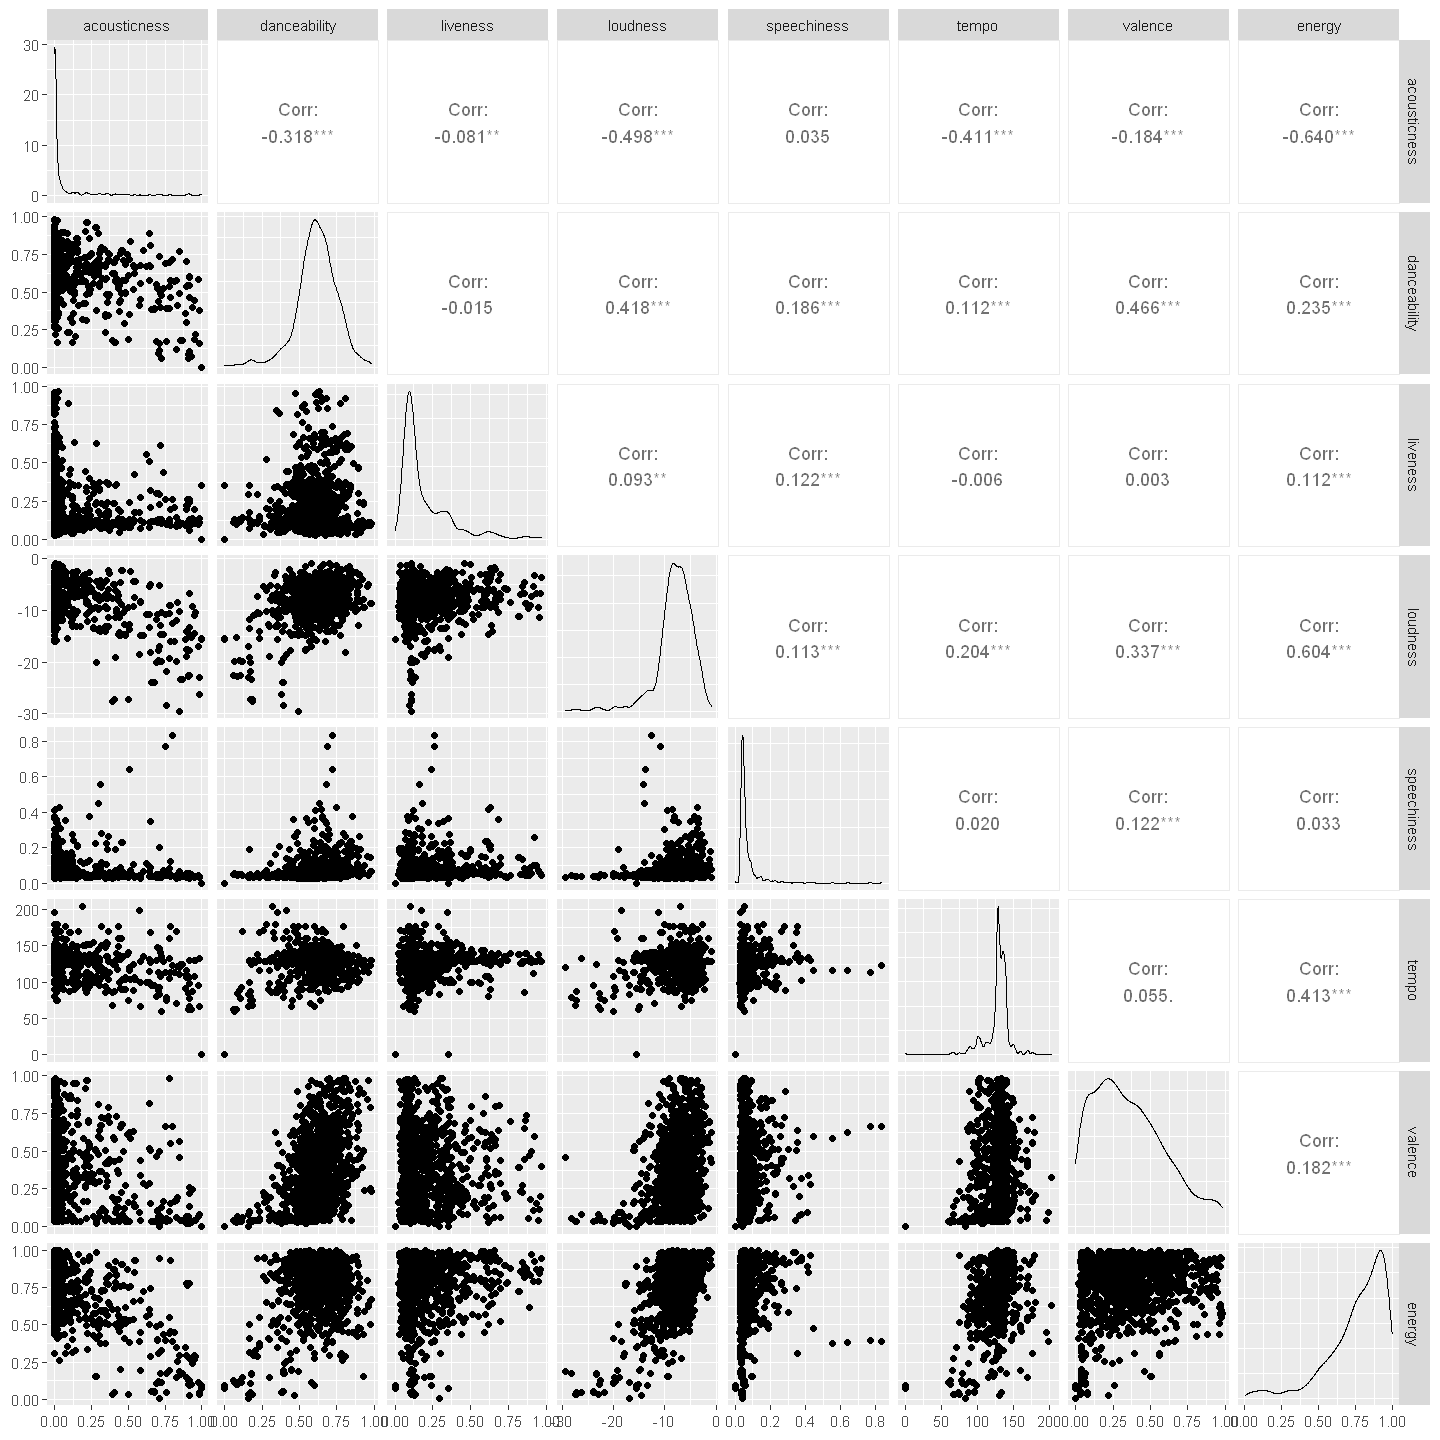

In [5]:
# creating paired matrix plot
house_paired <- house_train %>%
    ggpairs()

# visualizing paired plot
options(repr.plot.width = 12, repr.plot.height = 12)
house_paired

Figure 1: Scatterplot matrix of audio features with their Pearson correlation coefficients. The audio features included are acousticness, danceability, liveness, loudness, speechiness, tempo, valence, and energy.  

The correlations between predictor variables range between absolute values of 0.015 to 0.498. To assess multicollinearity, the variance inflation factor (VIF) can be used, which quantifies how much variance is inflated for each predictor variable. Variables with high VIF measurements suggest that existing correlations amongst predictor variables are skewing the results. This may lead to overfitting of the model, with unstable and inflated outputs. For this study, a conservative VIF threshold of 5 will be used to indicate significant multicollinearity.  

Variance inflation factors can be visualized below.

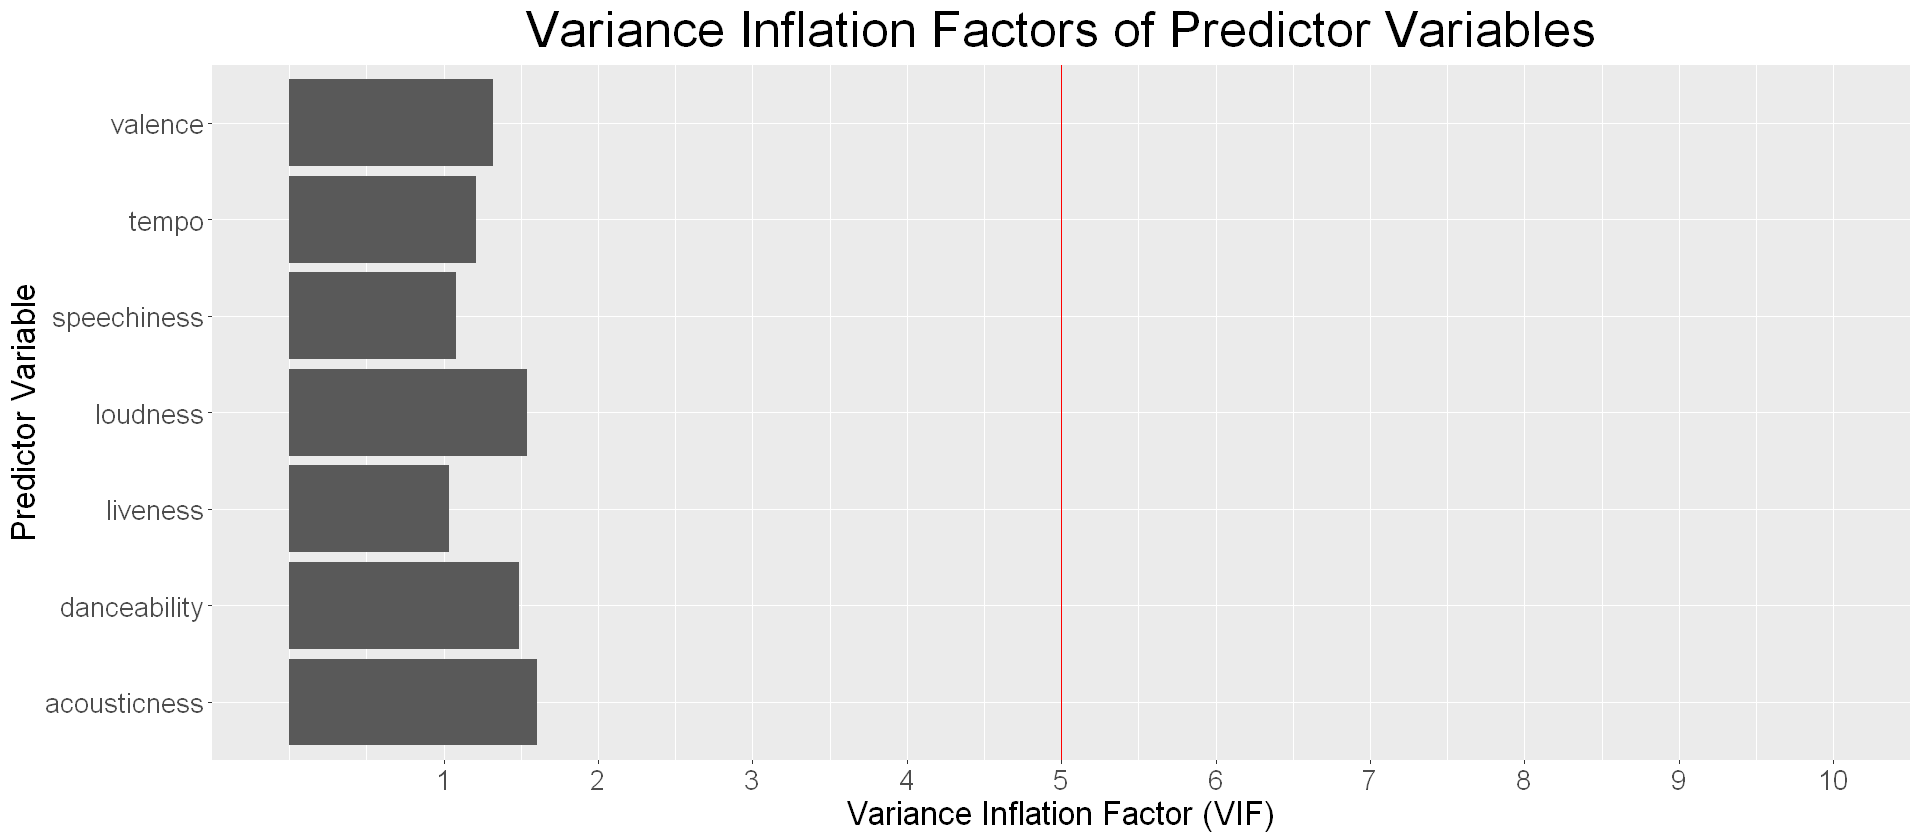

In [128]:
# creating linear regression model
lm_model <- lm(energy ~ ., data = house_train)

# creating dataframe of VIF values
vif_vals <- as.vector(vif(lm_model))
vif_labs <- as.vector(colnames(house_train))[1:7]
vif_df <- data.frame(vif_labs, vif_vals)

# creating VIF plot
vif_plot <- vif_df %>%
    ggplot(aes(x = vif_labs, y = vif_vals)) +
    geom_bar(stat = "identity") +
    geom_hline(yintercept = 5, colour = "red") +
    scale_y_continuous(breaks = 1:10, limit = c(0, 10)) +
    labs(title = "Variance Inflation Factors of Predictor Variables",
         x = "Predictor Variable",
         y = "Variance Inflation Factor (VIF)") +
    coord_flip() +
    theme(plot.title = element_text(hjust = 0.5, size = 30),
          text = element_text(size = 20))

# visualizing VIF plot
options(repr.plot.width = 16, repr.plot.height = 7)
vif_plot

Figure 2: Variance Inflation Factor of Predictor Variables. Predictor variables include acousticness, danceability, liveness, loudness, speechiness, tempo, and valence.  

It appears that all predictor variables are well below the threshold for multicollinearity, suggesting that using multiple predictors will not lead to significant output inflation or skewing.

On the contrary, the 3 predictor variables with the strongest correlations to energy are acousticness (-0.640), loudness (0.604), and tempo (0.413). They can be visualized individually below.

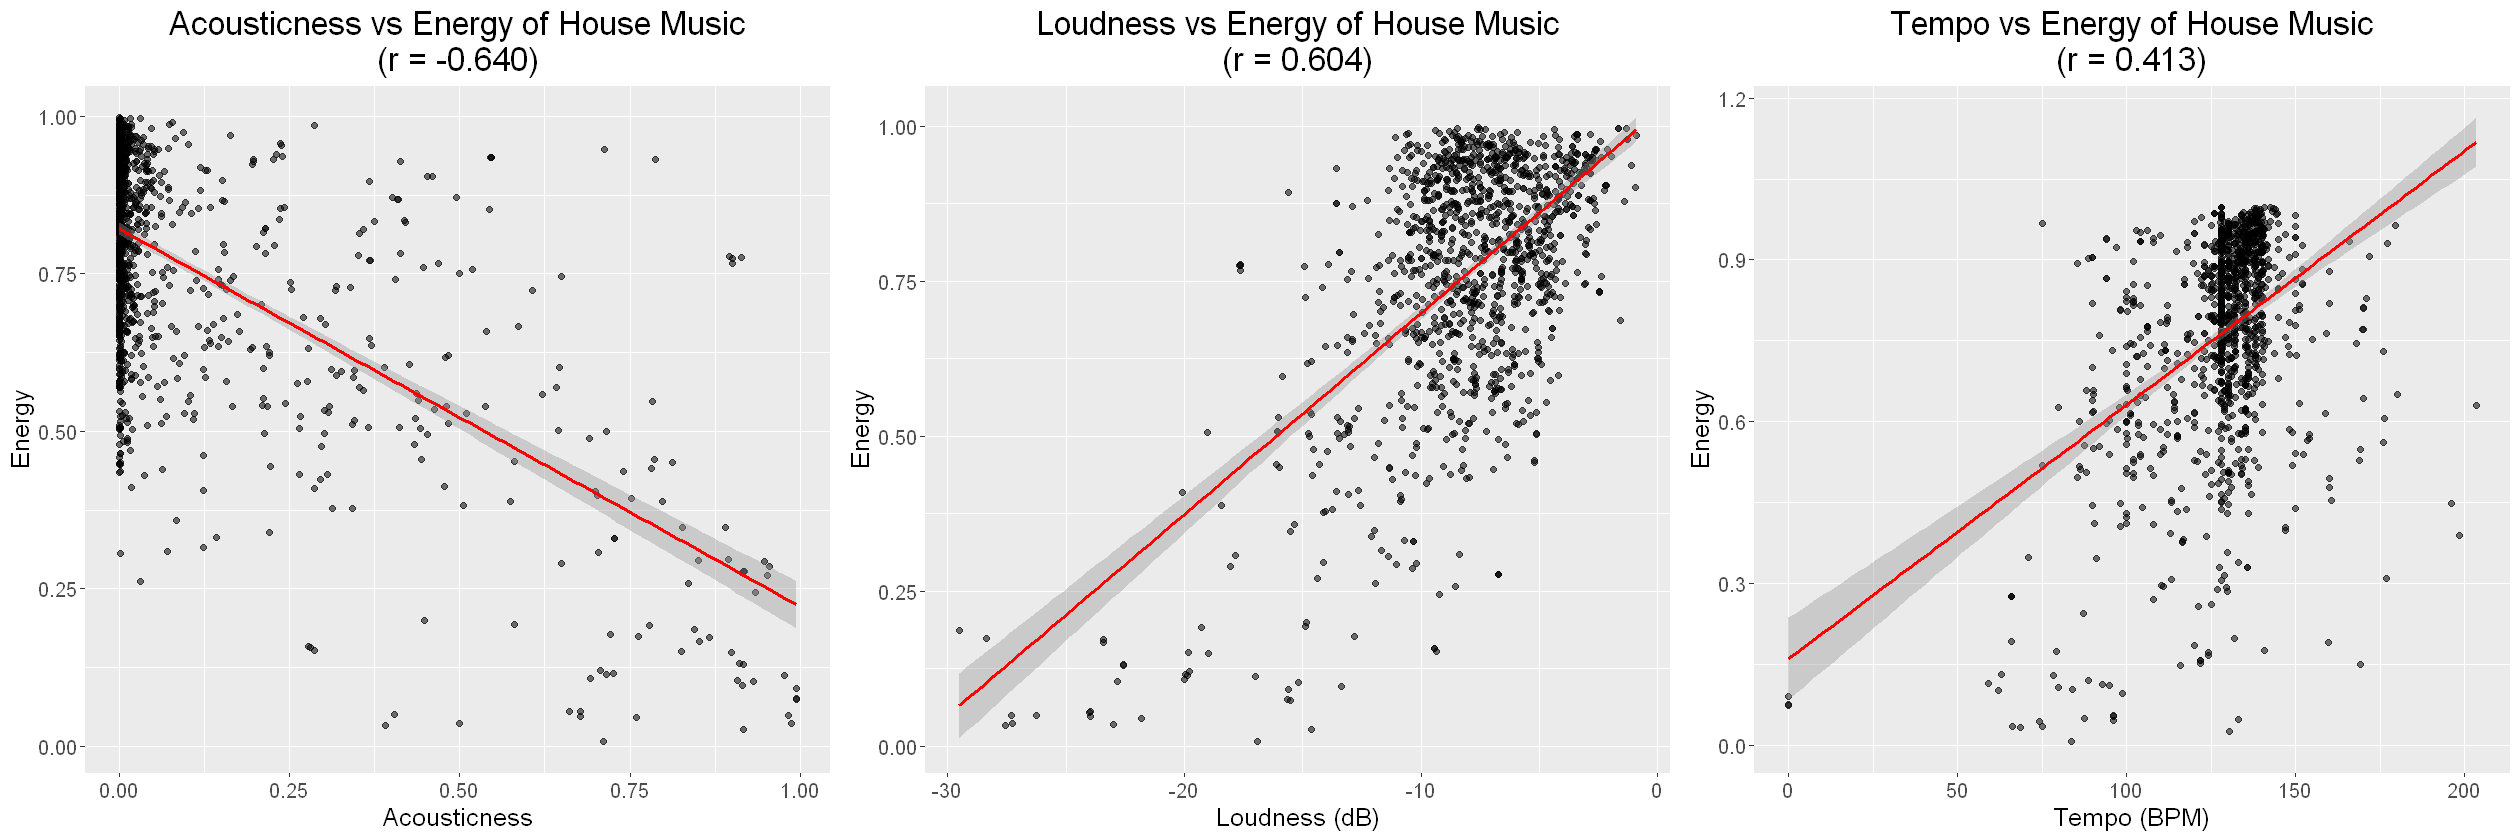

In [7]:
# acousticness vs energy
a <- ggplot(house_train, aes(x = acousticness, y = energy)) +
    geom_point(aes(alpha = 0.5)) +
    stat_smooth(method = "lm", col = "red") +
    labs(title = "Acousticness vs Energy of House Music\n(r = -0.640)",
         x = "Acousticness",
         y = "Energy") +
    theme(plot.title = element_text(hjust = 0.5, size = 20),
          text = element_text(size = 15),
          legend.position = "none")

# loudness vs energy
b <- ggplot(house_train, aes(x = loudness, y = energy)) +
    geom_point(aes(alpha = 0.5)) +
    stat_smooth(method = "lm", col = "red") +
    labs(title = "Loudness vs Energy of House Music\n(r = 0.604)",
         x = "Loudness (dB)",
         y = "Energy") +
    theme(plot.title = element_text(hjust = 0.5, size = 20),
          text = element_text(size = 15),
          legend.position = "none")
    
# tempo vs energy
c <- ggplot(house_train, aes(x = tempo, y = energy)) +
    geom_point(aes(alpha = 0.5)) +
    stat_smooth(method = "lm", col = "red") +
    labs(title = "Tempo vs Energy of House Music\n(r = 0.413)",
         x = "Tempo (BPM)",
         y = "Energy") +
    theme(plot.title = element_text(hjust = 0.5, size = 20),
          text = element_text(size = 15),
          legend.position = "none")

# visualizing them side by side
options(repr.plot.width = 21, repr.plot.height = 7)
plot_grid(a, b, c, nrow = 1, ncol = 3) %>%
    suppressMessages()


Figure 3.1 (Left): Acousticness vs Energy of House Music  
Figure 3.2 (Middle): Loudness vs Energy of House Music  
Figure 3.3 (Right): Tempo vs Energy of House Music  
  
Upon closer examination of the data, it is evident that the data is not well fitted for a linear regression. Despite having moderate correlations with energy, all 3 plots have a curved and irregular trending of points, with denser regions that show near-vertical trends. In such cases, transformations could be applied to the data in order to achieve linearity. However, for this study, the K-Nearest Neighbors regression method will be used instead.  

**K-Nearest Neighbors (KNN) Regression**  

The KNN regression is a predictive method that approximates the association between predictor variables and the response variable by assessing the closest observations in the same area of the training dataset. The KNN algorithm seeks the closest neighbors based on the Euclidian distance. The advantage to using KNN regression is that it is a simple non-parametric algorithm, which does not make assumptions regarding the distribution of the data. Thus, it will work well with the non-linear distributions seen in this study.  

It should be noted that KNN regression will not predict well beyond the range of values from the training data. Furthermore, it does not perform well with large numbers of predictors, and grows slow with large amounts of training data. Therefore, to avoid building an overly complex model, it is important to select an optimal combination of predictor variables.  

Below, variable selection is executed using the forward selection procedure. This procedure attempts to find an optimal subset of predictor variables by inserting them into the model one at a time. At each step, the predictor variable with the highest partial correlation is added to the model, and the k-neighbor hyperparameter is tuned to obtain the lowest root mean squared error (RMSE) value. This tuning occurs using 10-fold cross-validation to mitigate skewing of the data from sampling variation. 

In [114]:
# setting seed for reproducible results
set.seed(604)

# creating vector of predictor variable names
names <- house_train %>%
  dplyr::select(-energy) %>%
  colnames()

# creating empty tibble to store the results
selection_result <- tibble(size = integer(),
                     model_string = character(),
                     rmse = numeric())

# creating knn model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("regression")

# creating 10-fold cross-validation object
house_vfold <- vfold_cv(house_train, v = 10, strata = energy)

# creating k-neighbors trial range
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

# creating object to store total number of predictor variables
n_total <- length(names)

# creating vector to store selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # creating accuracy list object
    rmse_list <- list()
    # creating models_list list object
    models_list <- list()

    # for every predictor not yet added
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        new_predictors <- c(selected, names[[j]])
        model_string <- paste("energy", "~",
                              paste(new_predictors, collapse = " + "))

        # create a recipe from the model string
        house_recipe <- recipe(as.formula(model_string),
                               data = house_train) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors,
        # and collect the rmse for the best K
        rmse <- workflow() %>%
          add_recipe(house_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = house_vfold, grid = k_vals) %>%
          collect_metrics() %>%
          # filtering for rmse results
          filter(.metric == "rmse") %>%
          # filter for row with lowest rmse result
          filter(mean == min(mean))

        # storing rmse
        rmse <- rmse$mean

        # add this result to the dataframe
        rmse_list[[j]] <- rmse
        models_list[[j]] <- model_string
    }
    # index of minimum rmse
    jstar <- which.min(unlist(rmse_list))

    # storing new rmse entry
    selection_result <- selection_result %>%
      add_row(size = i,
              model_string = models_list[[jstar]],
              rmse = rmse_list[[jstar]])

    # selecting next predictor variable
    selected <- c(selected, names[[jstar]])
    # removing from worklist
    names <- names[-jstar]
}
selection_result

size,model_string,rmse
<int>,<chr>,<dbl>
1,energy ~ acousticness,0.1499998
2,energy ~ acousticness + loudness,0.1329956
3,energy ~ acousticness + loudness + tempo,0.1205682
4,energy ~ acousticness + loudness + tempo + danceability,0.1196843
5,energy ~ acousticness + loudness + tempo + danceability + valence,0.1177205
6,energy ~ acousticness + loudness + tempo + danceability + valence + liveness,0.1196487
7,energy ~ acousticness + loudness + tempo + danceability + valence + liveness + speechiness,0.1190604


Table 4: Root mean squared error (RMSE) results of forward selection. This table shows the lowest RMSE values obtained for each combination of predictor variables iterated through forward selection. Since there are a total of 7 predictor variables, forward selection has outputted 7 different combinations.  

The results of this table can be visualized below.

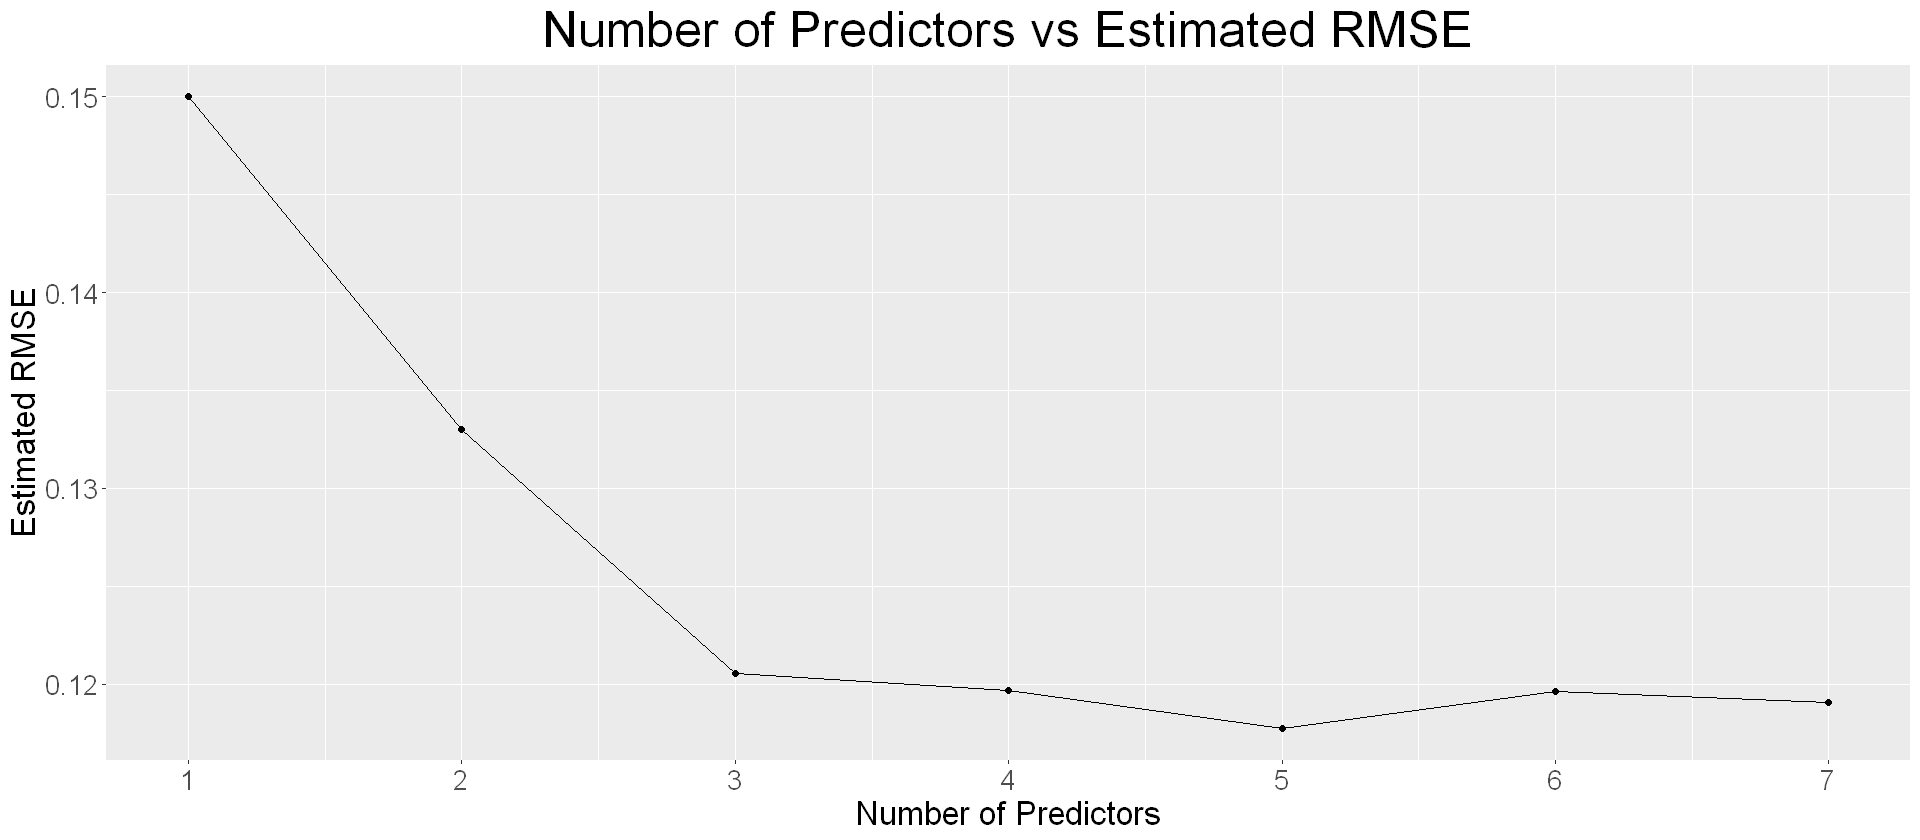

In [134]:
# creating plot of rmse vs number of predictors from forward selection results
selection_result_plot <- selection_result %>%
    ggplot(aes(x = size, y = rmse)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = 1:7) +
    labs(title = "Number of Predictors vs Estimated RMSE",
         x = "Number of Predictors",
         y = "Estimated RMSE") +
    theme(plot.title = element_text(hjust = 0.5, size = 30),
          text = element_text(size = 20))

# visualizing selection results plot
options(repr.plot.width = 16, repr.plot.height = 7)
selection_result_plot

Figure 4: Number of Predictors vs Estimated RMSE.  

According to the plot, the model with 5 predictor variables has the lowest RMSE value. However, it is important to note that the RMSE values will fluctuate due to sampling variation from cross-validation. It is also evident that there are greatly diminishing returns with increasing model predictors past 3 variables. Using too many predictor variables will lead to overfitting and excessive model complexity. While this may appear to fit the training data well with low bias, it will have poor generalizability to new data with higher variance. The two sources of error cannot be simultaneously minimized due to the bias-variance tradeoff. Thus, it is a better option to use the simpler model that still has significant decreases in RMSE.

For this study, the model with 3 predictors will be chosen, which include acousticness, loudness, and tempo. A detailed view of the model tuning can be visualized below.

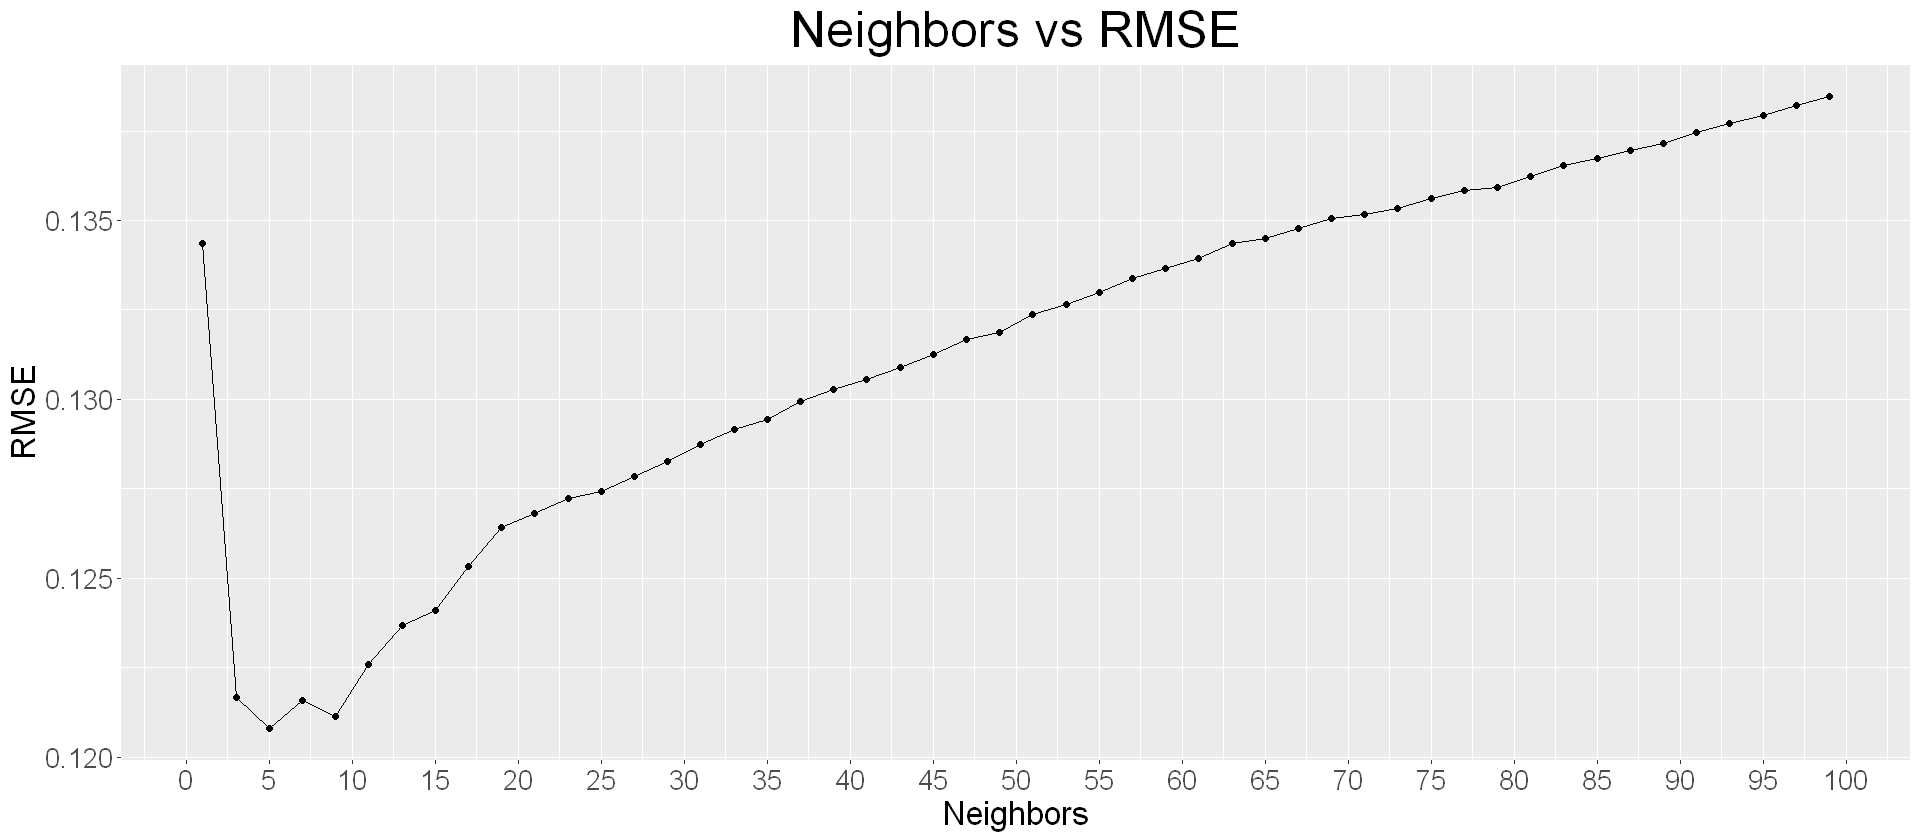

In [138]:
# setting seed for reproducible results
set.seed(604)

# creating recipe for 3 predictor multivariate knn regression
# using acousticness, loudness, and tempo
knn_recipe <- recipe(energy ~ acousticness + loudness + tempo,
                     data = house_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# creating knn specification with tuning neighbors
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

# creating 10 fold cross validation object
knn_vfold <- vfold_cv(house_train, v = 10, strata = energy)

# creating k-neighbors trial range
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

# results of tuning k-neighbors parameter
knn_results <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = knn_vfold, grid = k_vals) %>%
    collect_metrics() %>%
    filter(.metric == "rmse")

# creating plot of tuning results
knn_results_plot <- knn_results %>%
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = seq(from = 0, to = 100, by = 5)) +
    labs(title = "Neighbors vs RMSE",
         x = "Neighbors",
         y = "RMSE") +
    theme(plot.title = element_text(hjust = 0.5, size = 30),
          text = element_text(size = 20))
    
# visualizing plot
options(repr.plot.width = 16, repr.plot.height = 7)
knn_results_plot

# storing neighbors for lowest rmse
kmin <- knn_results_lowest %>%
    pull(neighbors)

Figure 5: Neighbors vs RMSE, showing the RMSE values associated with the multivariate KNN regression across different values of k-neighbors.  

Tuning the model shows that the lowest RMSE value occurs when k = 5 neighbors. As such, the model will be built using k = 5 neighbors, and subsequently tested on the testing dataset.

In [148]:
# adjusting knn specification for lowest rmse neighbor value
knn_spec_actual <- nearest_neighbor(weight_func = "rectangular",
                                    neighbors = kmin) %>%
    set_engine("kknn") %>%
    set_mode("regression")

# adjusting knn fit for new specification
knn_fit <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_spec_actual) %>%
    fit(data = house_train)

# using trained knn model to predict test data
knn_prediction <- knn_fit %>%
    predict(house_test) %>%
    bind_cols(house_test)
    
# metric summary for prediction
knn_prediction_metrics <- knn_prediction %>%
    metrics(truth = energy, estimate = .pred)
knn_prediction_metrics[1, 1] <- "rmpse"
knn_prediction_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmpse,standard,0.12200556
rsq,standard,0.57075009
mae,standard,0.09047252


Table 5: Multivariate KNN regression results. The root mean predicted square error (RMPSE) is a measure of how far the predicted values are from the observed values, on average. The R-squared value is a measure of how much variation of the response variable can be explained by the predictor variables. The mean absolute error (MAE) is a measure of the average magnitude of errors.  

An RMPSE value of 0.122 is relatively low, and indicates a well fitted model. 

**Methods**  
  
From the exploratory analysis, the focus will be on the predictor variables of loudness, tempo, and acousticness, and the response variable will be the energy rating. In the report, a multivariate linear regressive model will be generated to predict the energy rating based off of 1-3 predictor variables. The model curve can be plotted against each predictor variable separately for individual visualization. The accuracy of the regressive model can be assessed through a root-mean-squared-error (RMSE) plot to visualize the differences between predicted values and observed values in the testing dataset. A residuals plot can also be generated to assess whether the errors are indeed independent, symmetrical, and normally distributed. 

**Expected Outcomes and Significance**  
  
Evident from the scatterplot matrix, the response variable of the energy rating appears to have a moderate to moderately-weak correlations with acousticness, loudness, and tempo. After creating the model, we are expecting to find that the energy rating will be moderately associated with one or multiple of those predictor variables, and that given the measures of the predictor variables, an expected value can be generated for the energy rating with some degree of accuracy.  
  
This predictive model can be generalized to help recommend songs with high energy to consumers within the house music genre. In analyzing the data, the variables with stronger correlations to energy may help provide a framework in predicting ratings of other genres as well. Additionally, finding these insights between audio metrics is useful for artists and [emerging music creation AIs](https://www.frontiersin.org/articles/10.3389/frobt.2021.647028/full) for construction of more songs within the house music genre. These findings could also lead to further exploration of audio metrics in a more abstract scope, such as researching the energy levels and correlations in other genres, and how they compare to house music.

**References**  

https://www.google.com/url?q=https://newsroom.spotify.com/company-info/&sa=D&source=docs&ust=1646548657733947&usg=AOvVaw2-aNiFTZDrkhXIWRxPE4aU  
  
https://dl.acm.org/doi/10.1145/2959100.2959120  
  
https://www.allmusic.com/subgenre/house-ma0000002651?1646545415388&fbclid=IwAR2ZKQ2EAzLFX4E4FsCyNbLL17Y2Jrjmtqz0tW7dsIwkIn40YQT2QV1hYH8  
  
https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features
  
https://www.frontiersin.org/articles/10.3389/frobt.2021.647028/full